# Predicting stock prices with Autogluon project


## Data exploration

In [27]:
import pandas as pd
from io import StringIO

### Parameter definition

Let's use Apple (AAPL) as an example, with a lookback period of 3 years

In [55]:
# Parameters
ticker = 'AAPL'
lookback_months = 36

### Data Gathering

We'll get the data from `query1.finance.yahoo.com` providing above params, via a regular http request  

Sample data url: https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1550793600&period2=1645488000&interval=1d&events=history&includeAdjustedClose=true

In [78]:
import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import os
import boto3


def get_data_df(ticker, period1, period2, suffix=''):
    int_period1 = int(time.mktime(period1.timetuple()))
    int_period2 = int(time.mktime(period2.timetuple()))
    interval = '1d' # 1d, 1m    
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={int_period1}&period2={int_period2}&interval={interval}&events=history&includeAdjustedClose=true'
    print(url)
    df = pd.read_csv(url)
    df = df.rename(columns={'Adj Close': 'Adj_Close'})
    return df


In [79]:
period2 = datetime.date.today()
period1 = period2 - relativedelta(months=lookback_months)

df = get_data_df(ticker, period1, period2)
df

https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1550793600&period2=1645488000&interval=1d&events=history&includeAdjustedClose=true


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2019-02-22,42.895000,43.250000,42.845001,43.242500,42.105236,75652800
1,2019-02-25,43.540001,43.967499,43.487499,43.557499,42.411949,87493600
2,2019-02-26,43.427502,43.825001,43.292500,43.582500,42.436302,68280800
3,2019-02-27,43.302502,43.750000,43.182499,43.717499,42.567745,111341600
4,2019-02-28,43.580002,43.727501,43.230000,43.287498,42.149048,112861600
...,...,...,...,...,...,...,...
751,2022-02-14,167.369995,169.580002,166.559998,168.880005,168.880005,86185500
752,2022-02-15,170.970001,172.949997,170.250000,172.789993,172.789993,64286300
753,2022-02-16,171.850006,173.339996,170.050003,172.550003,172.550003,61177400
754,2022-02-17,171.029999,171.910004,168.470001,168.880005,168.880005,69589300


### Exploration

In [80]:
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2019-02-22,42.895000,43.250000,42.845001,43.242500,42.105236,75652800
1,2019-02-25,43.540001,43.967499,43.487499,43.557499,42.411949,87493600
2,2019-02-26,43.427502,43.825001,43.292500,43.582500,42.436302,68280800
3,2019-02-27,43.302502,43.750000,43.182499,43.717499,42.567745,111341600
4,2019-02-28,43.580002,43.727501,43.230000,43.287498,42.149048,112861600


Let's plot the evolution of the Adjusted Close price through time

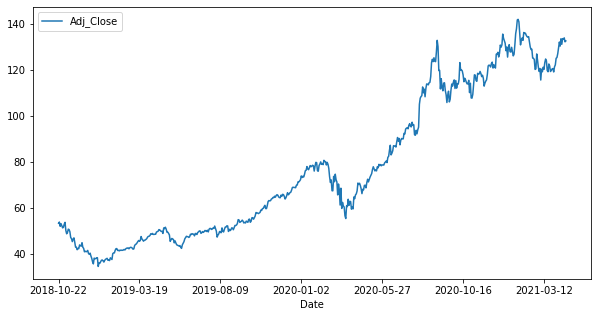

In [72]:
df.plot(x='Date', y='Adj_Close', figsize=(10,5))

For this stock, we can observe an ascending behavior in general. Prices between 40 and 140 aprox

Let's check the data distribution

In [73]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,628.000000,628.000000,628.000000,628.000000,628.000000,6.280000e+02
mean,78.181644,79.155991,77.198416,78.226035,77.156960,1.349292e+08
std,31.799664,32.194446,31.233977,31.725079,31.829701,6.111411e+07
min,35.994999,36.430000,35.500000,35.547501,34.464806,4.544800e+07
25%,50.683750,51.097500,50.239375,50.686250,49.475485,9.249275e+07
50%,68.684998,69.791252,67.537498,68.772499,67.759963,1.185214e+08
75%,113.964998,115.460001,112.227501,113.579998,112.508511,1.615198e+08
max,143.600006,145.089996,141.369995,143.160004,142.101807,4.265100e+08


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38618fcd90>,
      dtype=object)

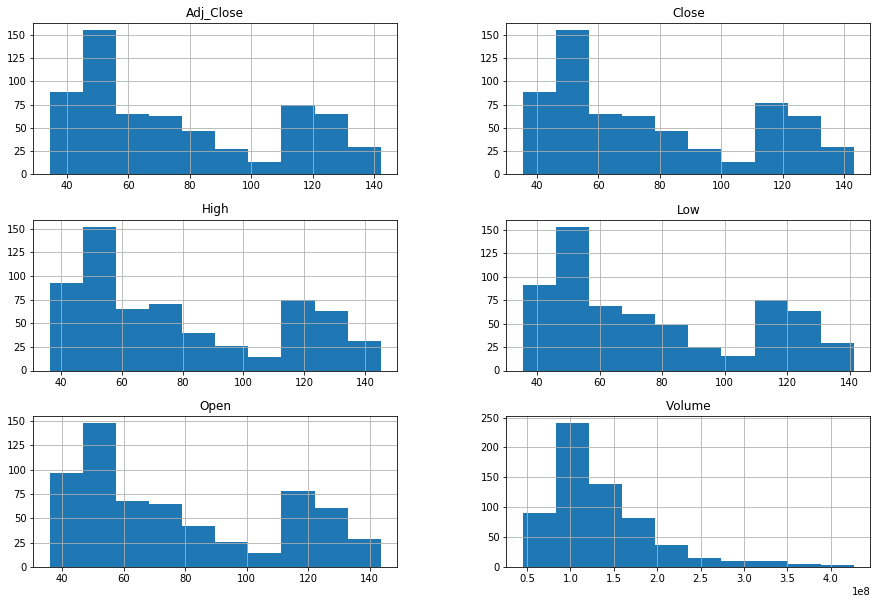

In [74]:
df.hist(figsize=(15,10))

We can observe that all numeric fields have a similar distribution, bimodal in this example.
This could be very dependent on the stock

Except for the volume, which follows a log normal distribution

Let's check the Gold (GLD) stock distribution for the same period

In [75]:
df_gld = get_data_df('GLD', period1, period2)
df_gld.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,157.695899,158.370622,156.927368,157.686666,157.686666,9.866372e+06
std,18.322348,18.409185,18.149848,18.293168,18.293168,5.306399e+06
min,119.669998,120.110001,119.540001,119.940002,119.940002,2.250900e+06
25%,141.765003,142.514999,141.177494,141.787494,141.787494,6.509725e+06
50%,164.055000,164.825005,163.480003,164.190002,164.190002,8.376150e+06
75%,170.627495,171.332497,170.149994,170.945003,170.945003,1.172858e+07
max,193.740005,194.449997,192.520004,193.889999,193.889999,4.535500e+07


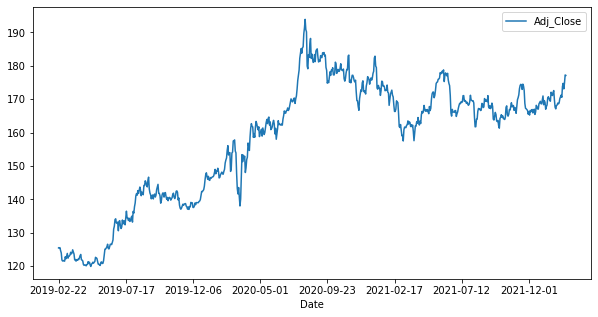

In [76]:
df_gld.plot(x='Date', y='Adj_Close', figsize=(10,5))

Gold also has an ascending behavior in general

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3861537f90>,
      dtype=object)

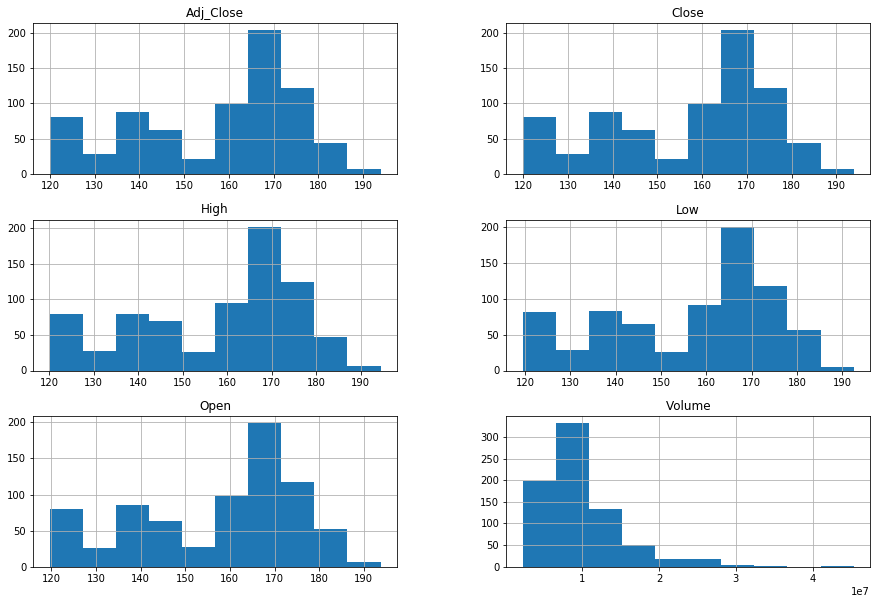

In [77]:
df_gld.hist(figsize=(15,10))

We can observe that the prices distribution is very different. However, the volume is also log normal
We don't notice the presence of outliers or atypical data.

### Data cleaning

The data comes clean from source (Yahoo Finance) so it does not need cleaning. Also, given it provides an Adjusted Close field, we don't need to do further calculations